# Text preprocessing

In [1]:
DATA = "data/"
TRAIN = f"{DATA}/train.csv"
TEST = f"{DATA}/test.csv"
TRAIN_LABEL = f"{DATA}/train_label.txt"
TRAIN_TITLE = f"{DATA}/train_title.txt"
TRAIN_TEXT = f"{DATA}/train_text.txt"
TEST_LABEL = f"{DATA}/test_label.txt"
TEST_TITLE = f"{DATA}/test_title.txt"
TEST_TEXT = f"{DATA}/test_text.txt"

TRAIN_NORM = f"{DATA}/train_norm.txt"
TEST_NORM = f"{DATA}/test_norm.txt"

In [2]:
# # Splt the csv into label, title, text
# import pandas as pd

# train = pd.read_csv(TRAIN)
# train_col = train.columns
# train[train_col[0]].to_csv(TRAIN_LABEL, index=False)
# train[train_col[1]].to_csv(TRAIN_TITLE, index=False)
# train[train_col[2]].to_csv(TRAIN_TEXT, index=False)

# test = pd.read_csv(TEST)
# test_col = test.columns
# test[test_col[0]].to_csv(TEST_LABEL, index=False)
# test[test_col[1]].to_csv(TEST_TITLE, index=False)
# test[test_col[2]].to_csv(TEST_TEXT, index=False)
# del train, test, pd

In [3]:
# from src.Normalizer import normalize_data
# normalize_data(TRAIN_TEXT, TRAIN_NORM)
# normalize_data(TEST_TEXT, TEST_NORM)

# Training skipgram with Negative Sampling model

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import DataLoader

from src.SGNS import SGNS, Corpus, CorpusData
from src.utils import tfb_projector, print_similar
%config InlineBackend.figure_formats = ['svg']


In [5]:
# Device Selection
if torch.backends.mps.is_available:
    device = "mps"  # OSX
elif torch.cuda.is_available:
    device = "cuda"
else:
    device = "cpu"

In [6]:
# This take sevarl time
# Read The corpus, create all the training pairs
sgns_corpus = Corpus(TRAIN_NORM, 2, 5)
# Create a custom Dataset
sgns_corpusdata = CorpusData(sgns_corpus)
# Dataloader
sgns_dataloader = DataLoader(sgns_corpusdata, batch_size=4096, shuffle=True)

In [21]:
sgns_corpus.total, sgns_corpus.vocab_size, len(sgns_corpusdata)

(1944289, 56465, 3286449)

In [22]:
N = sgns_corpus.vocab_size
H = 256
model = SGNS(N, H).to(device)
# model.load_state_dict(torch.load("sgns.pth"))
model.eval()

SGNS(
  (vEmbedding): Embedding(56465, 256)
  (uEmbedding): Embedding(56465, 256)
)

In [10]:
model, sgns_log = model.train_model(sgns_dataloader, 30, 1e-3, device)

Epoch 30/30: 100%|██████████| 803/803 [00:49<00:00, 16.32it/s, loss=1.40]


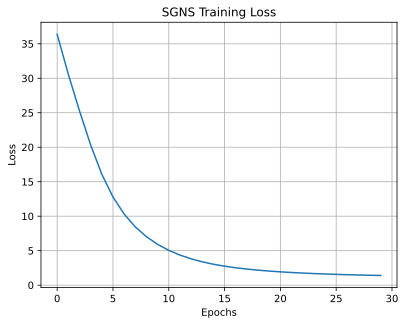

In [11]:
plt.plot(sgns_log)
plt.title("SGNS Training Loss")
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./report/figures/sgns_loss.pdf", bbox_inches='tight')
plt.show()

### Similar text exploration

In [14]:
# torch.save(model.state_dict(), "sgns.pth")

In [23]:
def print_similar(model, corpus, query_id, k=10):
    """
         Print the most similar words given a query
    """
    cos, dist = model.get_metrics(torch.tensor(query_id).long().to(device))
    cos, dist = cos.cpu(), dist.cpu()
    vals, idxs = cos.topk(k)

    for val, idx in zip(vals, idxs):
        print(f"{corpus.id2word[idx.item()]:<20}:{val.item():.3f}")

In [35]:
idx = sgns_corpus.word2id.get('google')
print_similar(model, sgns_corpus, idx, 5)
print("==================================")
idx = sgns_corpus.word2id.get('linux')
print_similar(model, sgns_corpus, idx, 5)
print("==================================")
idx = sgns_corpus.word2id.get('windows')
print_similar(model, sgns_corpus, idx,5)
print("==================================")
idx = sgns_corpus.word2id.get('war')
print_similar(model, sgns_corpus, idx, 5)
print("==================================")
idx = sgns_corpus.word2id.get('football')
print_similar(model, sgns_corpus, idx, 5)
print("==================================")
idx = sgns_corpus.word2id.get('food')
print_similar(model, sgns_corpus, idx, 5)
print("==================================")
idx = sgns_corpus.word2id.get('money')
print_similar(model, sgns_corpus, idx, 5)
print("==================================")
idx = sgns_corpus.word2id.get('police')
print_similar(model, sgns_corpus, idx, 5)


google              :1.000
search              :0.583
online              :0.570
data                :0.544
internet            :0.525
linux               :1.000
software            :0.600
internet            :0.582
technology          :0.557
products            :0.538
windows             :1.000
software            :0.605
users               :0.600
market              :0.548
search              :0.547
war                 :1.000
country             :0.649
government          :0.626
iraq                :0.623
officials           :0.594
football            :1.000
game                :0.626
team                :0.595
players             :0.556
time                :0.555
food                :1.000
business            :0.392
giant               :0.383
industry            :0.380
customers           :0.372
money               :1.000
business            :0.461
service             :0.460
corp                :0.457
management          :0.453
police              :1.000
killed              :0.627
m

### Visualization with Tensor projector

In [36]:
tfb_projector(model, sgns_corpus, "runs/sgns_final")

'runs/sgns_final_2024_07_07-23_23_09'

# Text Classifiers

In [41]:
import src.TextClassifier as TCl

In [48]:
word2id = sgns_corpus.word2id
texts = TCl.CorpusClassifier(
    f"{DATA}/train_norm.txt", f"{DATA}/train_label.txt", word2id
)
textsdata = TCl.ClassifierData(texts)
textsloader = TCl.dataLoader(textsdata, 2 * 4096)

In [49]:
embedding = model.vEmbedding
classf = TCl.TextClassifier(4, embedding, False)
classf = classf.to(device)

In [50]:
classf, tc_log = classf.train_classifier(textsloader, 70, 1e-3, device)

Epoch 70: 100%|██████████| 15/15 [00:01<00:00,  7.94it/s, accuracy=0.96, loss=0.12]


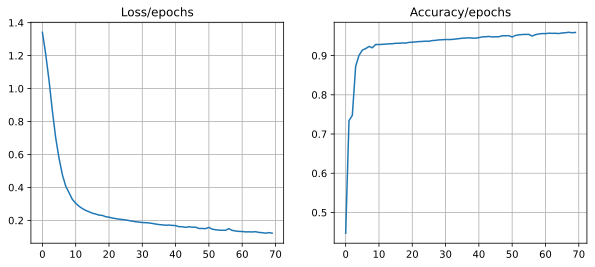

In [52]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(tc_log[:, 0])
plt.title("Loss/epochs")
plt.grid()
plt.subplot(122)
plt.plot(tc_log[:, 1])
plt.title("Accuracy/epochs")
plt.grid()
plt.savefig("./report/figures/class_loss.pdf", bbox_inches='tight')
plt.show()

# Testing Data

In [53]:
test_texts = TCl.CorpusClassifier(
    f"{DATA}/test_norm.txt", f"{DATA}/test_label.txt", word2id
)
test_textsdata = TCl.ClassifierData(test_texts)
test_textsloader = TCl.dataLoader(test_textsdata, 4096)

In [54]:
loss, acc, conf_matrix = classf.eval_classifier(test_textsloader, device)

Eval: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s, accuracy=0.90, loss=0.34]


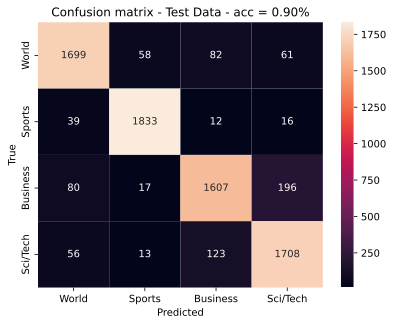

In [55]:
labels = ("World", "Sports", "Business", "Sci/Tech")
sns.heatmap(conf_matrix, annot=True, fmt=f".0f")
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels)
plt.title(fr"Confusion matrix - Test Data - acc = {acc:.2f}%")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("./report/figures/conf_mat.pdf", bbox_inches='tight')
plt.show()


In [28]:
model.vEmbedding.weight.shape

torch.Size([66081, 128])

In [40]:
sim, dist = model.get_metrics(1)

In [42]:
torch.argsort(sim)

tensor([   32,    37,     8,  ..., 61158, 26037, 60607], device='mps:0')

In [45]:
sg_corpus.id2word

NameError: name 'sg_corpus' is not defined

In [38]:
vv.mT @ model.vEmbedding.weight.mT

tensor([[-4.4080,  8.1489,  1.0988,  ...,  6.9751,  1.7384, -1.5707]],
       device='mps:0', grad_fn=<MmBackward0>)